# Lab 5 - Ensembles 
Here is what we will do:
1. Create a data set with two input features and a 3 category target
2. Train a decision tree on the data set for a baseline
3. Train 3 ensemble models
    - Serial Ada Boosted DT
    - Decision Forest
    - Ensemble of DT, SVM, and NN
3. Get model performance on train and test sets
4. Create appropriate graphs
5. Do a 10 fold cross validation with 

### Prepare the data

### Settings for the generated dataset
This data set will be spirals with noise
arms - This is the number of categories we will have
turns - How many times we go around the spiral
width - How wide is the spiral (percentage of the radius)
noise - How much noise we will add to the data.
size - The number of points to generate

In [1]:
arms = 3
turns = 1.5
width = 0.3
noise = .25
size = 4000

### The spirals will be based on the equation r=theta

Build set
Arm 0
Using offset 0.0
Arm 1
Using offset 2.0943951023931953
Arm 2
Using offset 4.1887902047863905


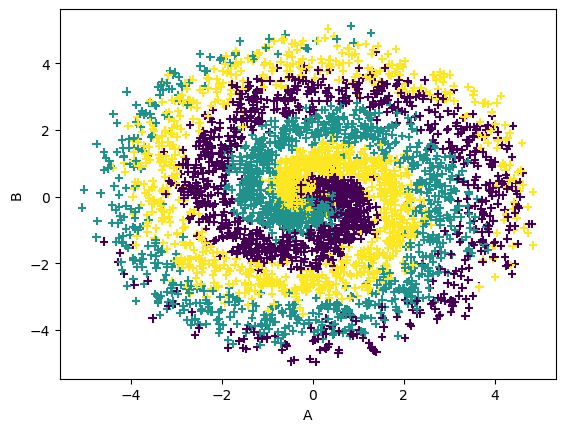

In [2]:
import numpy as np
import pandas as pd


def build_arm(n):
    print("Arm", n)
    points_per_arm = int(size/arms)
    #Get points on the curve
    theta_values = np.random.uniform(0, np.pi*turns, points_per_arm)
    r_values = theta_values
    target_values = [n] * points_per_arm
    
    #Add make the arm wider
    lower_fraction = (1 - width)*theta_values
    upper_fraction = (1 + width)*theta_values
    difference = upper_fraction - lower_fraction
    location = np.random.uniform(0, 1, points_per_arm)
    theta_values = theta_values + lower_fraction + difference*location
    
    #offset angle 
    offset = n*2*np.pi/arms
    print('Using offset', offset)
    theta_values = theta_values + offset
    
    #draw the noise from a distribution centered on 0.0 with a standard deviation of noise
    x_noise_values = np.random.normal(0, noise, points_per_arm)
    y_noise_values = np.random.normal(0, noise, points_per_arm)
    x_values = r_values * np.sin(theta_values) + x_noise_values
    y_values = r_values * np.cos(theta_values) + y_noise_values
    
    
    return x_values, y_values, target_values
    

def build_set():
    data_x = np.array([])
    data_y = np.array([])
    data_t = np.array([])
    print("Build set")
    for i in range(0,arms):
        x, y, t = build_arm(i)
        #print(data_x)
        #print(x)
        #print(y)
        #print(t)
        # add each arm to the data set
        data_x=np.append(data_x, x)
        data_y=np.append(data_y, y)
        data_t=np.append(data_t, t)
     # create a dictionary with each feature
    d = {}
    d["A"] = data_x
    d["B"] = data_y
    d["Class"] = data_t

    #print(d)

    # Create the data frame from the dictionary
    
    dataframe = pd.DataFrame(data=d)
    return dataframe
    

spiral = build_set()

import matplotlib.pyplot as plt

#shuffle before plotting so we don't always overwrite with the same color
shuffled = spiral.sample(frac=1)
plt.scatter(shuffled['A'], shuffled['B'], c=shuffled['Class'], marker='+')

plt.xlabel('A')
plt.ylabel('B')
plt.show()
    




### Stratified Test/Train Data Split

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_indices, test_indices in splitter.split(spiral, spiral['Class']):
    train_set = spiral.iloc[train_indices]
    test_set = spiral.iloc[test_indices]
    



### A Helpful plotting function for showing true and false for the categories

In [4]:
import matplotlib.pyplot as plt

def plot2FeatureBinaryConfusion(data_set, feature1Label, feature2Label, targetLabel, predicted, positive=1, negative=0):
## assumes that the target is 0/1

    
    target = data_set[targetLabel]
    
    # Filter with feature 1
    feature1_positives = np.ma.masked_where(target==negative, 
                     data_set[feature1Label])
    true_positive = np.ma.masked_where(predicted!=target, feature1_positives)
    false_negative = np.ma.masked_where(predicted==target, feature1_positives)
    feature1_negatives = np.ma.masked_where(target==positive, 
                     data_set[feature1Label])
    true_negative = np.ma.masked_where(predicted!=target, feature1_negatives)
    false_positive = np.ma.masked_where(predicted==target,feature1_negatives)

   
    feature2 = data_set[feature2Label]
    plt.scatter(true_positive, feature2, c='green', marker='o')
    plt.scatter(false_positive, feature2, c='red', marker='^')
    plt.scatter(true_negative, feature2, c='blue', marker='o')
    plt.scatter(false_negative, feature2, c='orange', marker='^')



    plt.xlabel(feature1Label)
    plt.ylabel(feature2Label)
    plt.legend(['True Positive', 'False Positive', 'True Negative', 'False Negative'])
    plt.show()

### Train and evaluate Decision Tree model 

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

tree_model = DecisionTreeClassifier()
tree_model.fit(X,y)

y_pred = tree_model.predict(X)
print('Results for decision tree on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = tree_model.predict(X_test)
print('Results for decision tree on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))



Results for decision tree on training data
  Default settings
Confusion Matrix
[[1067    0    0]
 [   0 1066    0]
 [   0    0 1066]]
Accuracy is   1.0
Precision is  1.0
Recall is     1.0
F1 is         1.0

Results for decision tree on test data
  Default settings
Confusion Matrix
[[202  27  37]
 [ 22 223  22]
 [ 27  32 208]]
Accuracy is   0.79125
Precision is  0.7915125137746883
Recall is     0.79125
F1 is         0.7909597985435097


### Train and evaluate SVC model 

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

svc_model = SVC()
svc_model.fit(X,y)

y_pred = svc_model.predict(X)
print('Results for svc on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = svc_model.predict(X_test)
print('Results for svc on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))



Results for svc on training data
  Default settings
Confusion Matrix
[[812 113 142]
 [207 708 151]
 [176 138 752]]
Accuracy is   0.7102219443576118
Precision is  0.7124510833824873
Recall is     0.7102219443576118
F1 is         0.7098913620510715

Results for svc on test data
  Default settings
Confusion Matrix
[[205  20  41]
 [ 46 193  28]
 [ 38  36 193]]
Accuracy is   0.73875
Precision is  0.7404001680538154
Recall is     0.73875
F1 is         0.7388265740517411


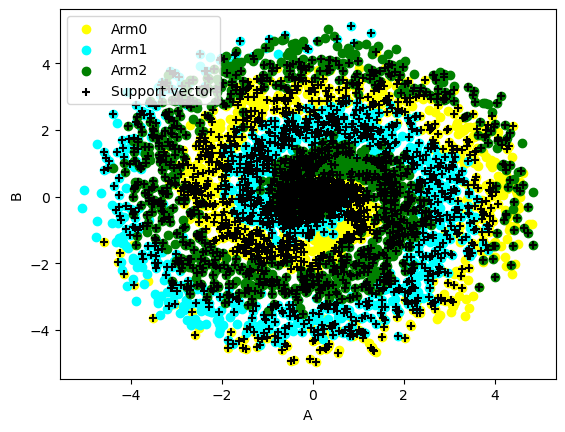

In [7]:
import matplotlib.pyplot as plt
arm0_A = np.ma.masked_where(spiral['Class']!=0, 
                     spiral['A'])

arm1_A = np.ma.masked_where(spiral['Class']!=1, 
                     spiral['A'])

arm2_A = np.ma.masked_where(spiral['Class']!=2, 
                     spiral['A'])



# get the values for the support vectors (the special instances)
support_x = [x for (x,y) in svc_model.support_vectors_]
support_y = [y for (x,y) in svc_model.support_vectors_]




b = spiral['B']
plt.scatter(arm0_A, b, c='yellow', marker='o')
plt.scatter(arm1_A, b, c='cyan', marker='o')
plt.scatter(arm2_A, b, c='green', marker='o')
plt.scatter(support_x, support_y, c='black', marker='+')

plt.xlabel('A')
plt.ylabel('B')
plt.legend(['Arm0', 'Arm1', 'Arm2','Support vector'])
plt.show()

### Train and evaluate Neural Net model 

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

nn_model = MLPClassifier(hidden_layer_sizes=(50, 25, 10),
                         solver='lbfgs')
nn_model.fit(X,y)

y_pred = nn_model.predict(X)


print('Results for NN on train data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = nn_model.predict(X_test)
print('Results for NN on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))




Results for NN on train data
  Default settings
Confusion Matrix
[[897  81  89]
 [ 95 892  79]
 [ 96  89 881]]
Accuracy is   0.8346358236949046
Precision is  0.8347370073830643
Recall is     0.8346358236949046
F1 is         0.8346411217008468

Results for NN on test data
  Default settings
Confusion Matrix
[[223  16  27]
 [ 22 227  18]
 [ 21  21 225]]
Accuracy is   0.84375
Precision is  0.8438494318181818
Recall is     0.84375
F1 is         0.8437818782943534


C:\Users\naiem\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [9]:
print(confusion_matrix(y, y_pred))
print('Accuracy is ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is ', recall_score(y,y_pred, average='weighted'))
print('F1 is ', f1_score(y, y_pred, average='weighted'))

[[897  81  89]
 [ 95 892  79]
 [ 96  89 881]]
Accuracy is  0.8346358236949046
Precision is  0.8347370073830643
Recall is  0.8346358236949046
F1 is  0.8346411217008468


### Train and evaluate ADA boosted model

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import AdaBoostClassifier
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

ada_model = AdaBoostClassifier(n_estimators=150)
ada_model.fit(X,y)
y_pred = ada_model.predict(X)

print('Results for ADA  on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = ada_model.predict(X_test)
print('Results for ADA  on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))




Results for ADA  on training data
  Default settings
Confusion Matrix
[[743 148 176]
 [209 662 195]
 [180 182 704]]
Accuracy is   0.6592685214129416
Precision is  0.6595266281543981
Recall is     0.6592685214129416
F1 is         0.6589190598787771

Results for ADA  on test data
  Default settings
Confusion Matrix
[[181  37  48]
 [ 61 157  49]
 [ 54  41 172]]
Accuracy is   0.6375
Precision is  0.6396941480009235
Recall is     0.6375
F1 is         0.637130319218161


### Train and evaluate Random Forest model


In [11]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

rf_model = RandomForestClassifier(n_estimators=150)
rf_model.fit(X,y)
y_pred = rf_model.predict(X)

print('Results for Random Forest on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = rf_model.predict(X_test)
print('Results for  Random Forest on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))





Results for Random Forest on training data
  Default settings
Confusion Matrix
[[1067    0    0]
 [   0 1066    0]
 [   0    0 1066]]
Accuracy is   1.0
Precision is  1.0
Recall is     1.0
F1 is         1.0

Results for  Random Forest on test data
  Default settings
Confusion Matrix
[[220  20  26]
 [ 24 222  21]
 [ 23  24 220]]
Accuracy is   0.8275
Precision is  0.8275132705358902
Recall is     0.8275
F1 is         0.8275046904315196


### Train and evaluate Voting model
We build it out of three different kinds of classifiers
One each of DT, SVC and NN

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']


# Build the classifiers
vc1_dt = DecisionTreeClassifier()
vc2_svm = SVC()
vc3_nn = MLPClassifier(hidden_layer_sizes=(50, 25, 10),
solver='lbfgs')


# Bundle into a list with names
vcList = [('DT',vc1_dt),
('SVM',vc2_svm),
('NN',vc3_nn)]


vote_model = VotingClassifier(vcList)
vote_model.fit(X,y)
y_pred = vote_model.predict(X)

print('Results for Voting Ensemble on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = vote_model.predict(X_test)
print('Results for Voting Ensemble on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))


C:\Users\naiem\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Results for Voting Ensemble on training data
  Default settings
Confusion Matrix
[[976  55  36]
 [ 68 934  64]
 [115  34 917]]
Accuracy is   0.8837136605189122
Precision is  0.8855790138774607
Recall is     0.8837136605189122
F1 is         0.8838571217382939

Results for Voting Ensemble on test data
  Default settings
Confusion Matrix
[[231  19  16]
 [ 26 222  19]
 [ 27  16 224]]
Accuracy is   0.84625
Precision is  0.8473952576802704
Recall is     0.84625
F1 is         0.8463543566597974


### Cross Validate a Decision Tree model


In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

accuracy_list = np.array([])
f1_list = np.array([])

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

for train_indices, validate_indices in splitter.split(spiral, 
spiral['Class']):
    train_set = spiral.iloc[train_indices]
    validate_set = spiral.iloc[validate_indices]
    X = train_set[['A','B' ]]
    y = train_set['Class']
    X_validate = validate_set[['A','B']]
    y_validate = validate_set['Class']
    model = DecisionTreeClassifier()
    model.fit(X,y)
    y_validate_pred = model.predict(X_validate)
    accuracy = accuracy_score(y_validate, y_validate_pred)
    print("Confusion Matrix")
    print(confusion_matrix(y_validate, y_validate_pred))
    print('Accuracy is ', accuracy)
    accuracy_list = np.insert(accuracy_list, 0, accuracy)

print("Accuracy values", accuracy_list)
print(" Average of ", np.average(accuracy_list))
print(" StDev of ", np.std(accuracy_list))




Confusion Matrix
[[107  12  15]
 [ 24  87  22]
 [ 15  13 105]]
Accuracy is  0.7475
Confusion Matrix
[[113  10  11]
 [ 15  99  19]
 [ 12  17 104]]
Accuracy is  0.79
Confusion Matrix
[[104  14  16]
 [ 19 101  13]
 [ 10  18 105]]
Accuracy is  0.775
Confusion Matrix
[[104  13  16]
 [ 21  99  14]
 [ 15  19  99]]
Accuracy is  0.755
Confusion Matrix
[[94 16 23]
 [18 96 20]
 [20 16 97]]
Accuracy is  0.7175
Confusion Matrix
[[ 97  15  21]
 [ 14 105  15]
 [ 16  21  96]]
Accuracy is  0.745
Confusion Matrix
[[ 92  23  18]
 [ 12 108  13]
 [ 16   8 110]]
Accuracy is  0.775
Confusion Matrix
[[104  12  17]
 [ 20  97  16]
 [ 19  14 101]]
Accuracy is  0.755
Confusion Matrix
[[107  12  14]
 [ 19  94  20]
 [ 19  14 101]]
Accuracy is  0.755
Confusion Matrix
[[103  18  12]
 [ 18  99  16]
 [ 21  23  89]]
Accuracy is  0.7293233082706767
Accuracy values [0.72932331 0.755      0.755      0.775      0.745      0.7175
 0.755      0.775      0.79       0.7475    ]
 Average of  0.7544323308270677
 StDev of  0.02059

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

accuracy_list = np.array([])
f1_list = np.array([])

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

for train_indices, validate_indices in splitter.split(spiral, spiral['Class']):
    train_set = spiral.iloc[train_indices]
    X = train_set[['A','B' ]]
    y = train_set['Class']
    X_validate = spiral.iloc[validate_indices][['A','B']]
    y_validate = spiral.iloc[validate_indices]['Class']

    model = DecisionTreeClassifier()
    model.fit(X, y)

    y_validate_pred = model.predict(X_validate)

    accuracy = accuracy_score(y_validate, y_validate_pred)


    accuracy_list = np.insert(accuracy_list,0, accuracy)


print("Confusion Matrix")
print(confusion_matrix(y_validate, y_validate_pred))

print("Accuracy values", accuracy_list)
print(" Average of ", np.average(accuracy_list))
print(" StDev of ", np.std(accuracy_list))


Confusion Matrix
[[105  17  11]
 [ 18  99  16]
 [ 22  23  88]]
Accuracy values [0.73182957 0.76       0.76       0.785      0.7525     0.7175
 0.7425     0.7875     0.7925     0.75      ]
 Average of  0.7579329573934837
 StDev of  0.02336042862047114


In [15]:
# Pick one of the adjustable parameters for the data set and change it
# change arms = 3   to 4
arms = 4
turns = 1.5
width = 0.3
noise = .25
size = 4000

Build set
Arm 0
Using offset 0.0
Arm 1
Using offset 1.5707963267948966
Arm 2
Using offset 3.141592653589793
Arm 3
Using offset 4.71238898038469


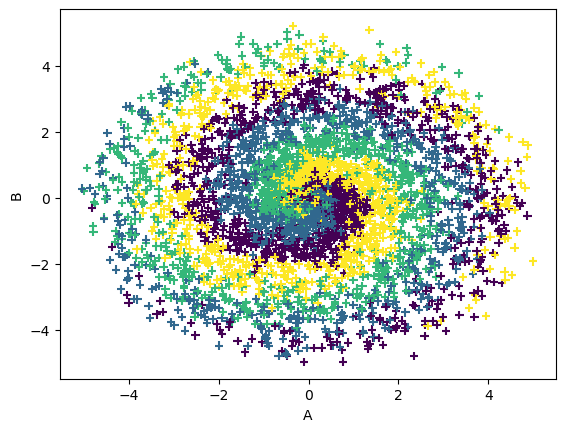

In [16]:
import numpy as np
import pandas as pd


def build_arm(n):
    print("Arm", n)
    points_per_arm = int(size/arms)
    #Get points on the curve
    theta_values = np.random.uniform(0, np.pi*turns, points_per_arm)
    r_values = theta_values
    target_values = [n] * points_per_arm
    
    #Add make the arm wider
    lower_fraction = (1 - width)*theta_values
    upper_fraction = (1 + width)*theta_values
    difference = upper_fraction - lower_fraction
    location = np.random.uniform(0, 1, points_per_arm)
    theta_values = theta_values + lower_fraction + difference*location
    
    #offset angle 
    offset = n*2*np.pi/arms
    print('Using offset', offset)
    theta_values = theta_values + offset
    
    #draw the noise from a distribution centered on 0.0 with a standard deviation of noise
    x_noise_values = np.random.normal(0, noise, points_per_arm)
    y_noise_values = np.random.normal(0, noise, points_per_arm)
    x_values = r_values * np.sin(theta_values) + x_noise_values
    y_values = r_values * np.cos(theta_values) + y_noise_values
    
    
    return x_values, y_values, target_values
    

def build_set():
    data_x = np.array([])
    data_y = np.array([])
    data_t = np.array([])
    print("Build set")
    for i in range(0,arms):
        x, y, t = build_arm(i)
        #print(data_x)
        #print(x)
        #print(y)
        #print(t)
        # add each arm to the data set
        data_x=np.append(data_x, x)
        data_y=np.append(data_y, y)
        data_t=np.append(data_t, t)
     # create a dictionary with each feature
    d = {}
    d["A"] = data_x
    d["B"] = data_y
    d["Class"] = data_t

    #print(d)

    # Create the data frame from the dictionary
    
    dataframe = pd.DataFrame(data=d)
    return dataframe
    

spiral = build_set()

import matplotlib.pyplot as plt

#shuffle before plotting so we don't always overwrite with the same color
shuffled = spiral.sample(frac=1)
plt.scatter(shuffled['A'], shuffled['B'], c=shuffled['Class'], marker='+')

plt.xlabel('A')
plt.ylabel('B')
plt.show()
    

In [17]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

svc_model = SVC()
svc_model.fit(X,y)

y_pred = svc_model.predict(X)
print('Results for svc on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = svc_model.predict(X_test)
print('Results for svc on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))


Results for svc on training data
  Default settings
Confusion Matrix
[[937 118 145]
 [217 826 157]
 [178 159 863]]
Accuracy is   0.7294444444444445
Precision is  0.7310309042500607
Recall is     0.7294444444444445
F1 is         0.7290871118095217

Results for svc on test data
  Default settings
Confusion Matrix
[[208  21  37]
 [ 43 196  28]
 [ 37  34 196]]
Accuracy is   0.75
Precision is  0.7513886026774129
Recall is     0.75
F1 is         0.7500267487293659


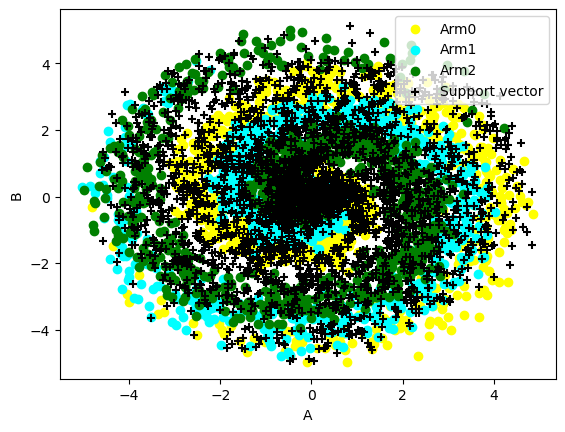

In [18]:
import matplotlib.pyplot as plt
arm0_A = np.ma.masked_where(spiral['Class']!=0, 
                     spiral['A'])

arm1_A = np.ma.masked_where(spiral['Class']!=1, 
                     spiral['A'])

arm2_A = np.ma.masked_where(spiral['Class']!=2, 
                     spiral['A'])



# get the values for the support vectors (the special instances)
support_x = [x for (x,y) in svc_model.support_vectors_]
support_y = [y for (x,y) in svc_model.support_vectors_]




b = spiral['B']
plt.scatter(arm0_A, b, c='yellow', marker='o')
plt.scatter(arm1_A, b, c='cyan', marker='o')
plt.scatter(arm2_A, b, c='green', marker='o')
plt.scatter(support_x, support_y, c='black', marker='+')

plt.xlabel('A')
plt.ylabel('B')
plt.legend(['Arm0', 'Arm1', 'Arm2','Support vector'])
plt.show()

In [19]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
  

X = train_set[['A','B' ]]
y = train_set['Class']

X_test = test_set[['A','B']]
y_test = test_set['Class']

rf_model = RandomForestClassifier(n_estimators=150)
rf_model.fit(X,y)
y_pred = rf_model.predict(X)

print('Results for Random Forest on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred, average='weighted'))
print('Recall is    ', recall_score(y,y_pred, average='weighted'))
print('F1 is        ', f1_score(y, y_pred, average='weighted'))
print()

y_test_pred = rf_model.predict(X_test)
print('Results for  Random Forest on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred, average='weighted'))
print('Recall is    ', recall_score(y_test,y_test_pred, average='weighted'))
print('F1 is        ', f1_score(y_test, y_test_pred, average='weighted'))





Results for Random Forest on training data
  Default settings
Confusion Matrix
[[1200    0    0]
 [   0 1200    0]
 [   0    0 1200]]
Accuracy is   1.0
Precision is  1.0
Recall is     1.0
F1 is         1.0

Results for  Random Forest on test data
  Default settings
Confusion Matrix
[[258   5   3]
 [  2 265   0]
 [  1   1 265]]
Accuracy is   0.985
Precision is  0.9850528545638647
Recall is     0.985
F1 is         0.9849777881387002


# Results
Basic results for our classification model to predict arm on the spiral data set

| Model | Training Features | Acc Train | F1 Train |Acc Test | F1 Test |
|:---|:---|:---|:---|:---|:---|
|Decision Tree|A,B|100.0|100.0|71.62 | 71.63 |
|SVC|A,B|71.58|71.58|70.5|70.42|
|MLP|A,B layers (50,25,10) lbfgs|80.06|80.13|77.87|77.91
|ADA|A,B 150 estimators|65.02|65.01|60.5|60.47|
|RFM|A,B 150 n_estimators|100.0|100.0|76.62|77.18|
|VCM|A,B,C 50,25,10 estimators|88.84|88.85|77.75|77.74|